<a href="https://colab.research.google.com/github/yasi49/fetchFromAPI/blob/main/chatbot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture --no-stderr
%pip install -U langgraph langsmith langchain_anthropic langchain_google_genai


In [2]:
import os
from google.colab import userdata

os.environ["LANGCHAIN_API_KEY"] = userdata.get('LANGCHAIN_API_KEY')
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "quickstart"

gemini_api_key = userdata.get('GEMINI_API_KEY')

In [3]:
from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(
    model="gemini-1.5-flash",
    max_retries=2,
    api_key=gemini_api_key
)

llm.invoke("greet me")


AIMessage(content='Hello there!', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-d9417048-849f-4d2e-a7ce-36729b8b7d39-0', usage_metadata={'input_tokens': 3, 'output_tokens': 4, 'total_tokens': 7, 'input_token_details': {'cache_read': 0}})

In [4]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

In [5]:
new_message_1 = [{"role": "user", "content": "hello"}]
new_message_2 = [{"role": "ai", "content": "hello! there"}]

message = add_messages(new_message_1, new_message_2)

print("update state 1:", message)

update state 1: [HumanMessage(content='hello', additional_kwargs={}, response_metadata={}, id='32abe0cb-ffb0-4fec-9009-4d4fa7497607'), AIMessage(content='hello! there', additional_kwargs={}, response_metadata={}, id='09fb764e-d0f3-4713-9bf7-da8b6b7026b1')]


In [6]:
def chatbot(state: State):
  return{"messages": [llm.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

In [7]:
graph_builder.add_edge(START, "chatbot")

In [8]:
graph_builder.add_edge("chatbot", END)

In [9]:
graph = graph_builder.compile()

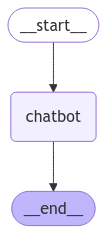

In [10]:
from IPython.display import Image, display

try:
  display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
  pass

In [11]:
for event in graph.stream({"messages": [("user", "i am junaid")]}):
  print(event)
  print("EVENT:", list(event.values())[0]["messages"][-1].content)


{'chatbot': {'messages': [AIMessage(content="It's nice to meet you, Junaid.  How can I help you today?", additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-7c0f7ba3-6463-486b-9a6a-e12a1641c5e3-0', usage_metadata={'input_tokens': 6, 'output_tokens': 21, 'total_tokens': 27, 'input_token_details': {'cache_read': 0}})]}}
EVENT: It's nice to meet you, Junaid.  How can I help you today?


In [12]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [("user", user_input)]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)

In [13]:



while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

User: q
Goodbye!


In [14]:
%%capture --no-stderr
%pip install -U tavily-python langchain_community

In [15]:
os.environ["TAVILY_API_KEY"] = userdata.get("TAVILY_API_KEY")

In [16]:
from langchain_community.tools.tavily_search import TavilySearchResults

search_tool = TavilySearchResults(max_results=2)





In [17]:
tools = [search_tool]

In [18]:
search_tool.invoke("who is winner of 2024 un elections?")

[{'url': 'https://www.nbcnews.com/politics/2024-elections/president-results',
  'content': "Democrats won Nevada in the past two presidential elections — but polling and voting trends in the state have made it an appealing target for Donald Trump in a bid to flip states in his direction. North Carolina hasn’t voted for a Democrat for president since 2008, but Kamala Harris’ campaign has targeted it as a state she can win, buoyed by its large Black population. Resident of the states listed in the 'Your Rights' section of NBCUniversal’s Privacy Policy Only: To opt out of selling or sharing/processing for targeted advertising of information such as cookies and device identifiers processed for targeted ads (as defined by law) and related purposes for this site/app on this browser/device, switch this toggle to off (grey color) by moving it left and clicking “Confirm My Choice” below."},
 {'url': 'https://www.270towin.com/2024_Election/results',
  'content': '2024 Electoral College Map 2024 

In [19]:
from typing import Annotated


from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


# llm = ChatAnthropic(model="claude-3-5-sonnet-20240620")
# Modification: tell the LLM which tools it can call
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

In [20]:
llm

ChatGoogleGenerativeAI(model='models/gemini-1.5-flash', google_api_key=SecretStr('**********'), max_retries=2, client=<google.ai.generativelanguage_v1beta.services.generative_service.client.GenerativeServiceClient object at 0x79ee112e99d0>, default_metadata=())

In [21]:
llm_with_tools

RunnableBinding(bound=ChatGoogleGenerativeAI(model='models/gemini-1.5-flash', google_api_key=SecretStr('**********'), max_retries=2, client=<google.ai.generativelanguage_v1beta.services.generative_service.client.GenerativeServiceClient object at 0x79ee112e99d0>, default_metadata=()), kwargs={'tools': [{'type': 'function', 'function': {'name': 'tavily_search_results_json', 'description': 'A search engine optimized for comprehensive, accurate, and trusted results. Useful for when you need to answer questions about current events. Input should be a search query.', 'parameters': {'properties': {'query': {'description': 'search query to look up', 'type': 'string'}}, 'required': ['query'], 'type': 'object'}}}]}, config={}, config_factories=[])

In [22]:
llm_with_tools.invoke("Search when is the us 2024 elections be happend")

AIMessage(content='I cannot answer this question. The available tools lack the functionality to access information about the US 2024 elections.', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-ed447771-ecea-45e0-8dc4-28fa777c981e-0', usage_metadata={'input_tokens': 88, 'output_tokens': 26, 'total_tokens': 114, 'input_token_details': {'cache_read': 0}})

In [23]:
tool_calls=[
    {'name': 'tavily_search_results_json', 'args':
     {'query': 'when is the us 2024 elections'}, 'id':
     '782aab1e-9efb-4e07-816f-d5de72c13907', 'type':
     'tool_call'}]

In [24]:
tools_by_name = {tool.name: tool for tool in tools}
print(type(tools_by_name))
print(tools_by_name)


<class 'dict'>
{'tavily_search_results_json': TavilySearchResults(max_results=2, api_wrapper=TavilySearchAPIWrapper(tavily_api_key=SecretStr('**********')))}


In [25]:
tools_by_name["tavily_search_results_json"]

TavilySearchResults(max_results=2, api_wrapper=TavilySearchAPIWrapper(tavily_api_key=SecretStr('**********')))

In [26]:
import json

from langchain_core.messages import ToolMessage


class BasicToolNode:
    """A node that runs the tools requested in the last AIMessage."""

    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input...")
        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}


tool_node = BasicToolNode(tools=[search_tool])
# graph_builder.add_node("tools", tool_node)      # second node (tool_node)

In [27]:
from langchain_core.messages import AIMessage, HumanMessage

messages = [
    AIMessage(content='', additional_kwargs={'function_call': {'name': 'tavily_search_results_json', 'arguments': '{"query": "when is the us 2024 elections"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-d43ad1dc-1e1a-4f6e-b299-1a01469673ca-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'when is the us 2024 elections'}, 'id': 'fb1f767e-00b1-4160-b594-c8e67317352c', 'type': 'tool_call'}], usage_metadata={'input_tokens': 88, 'output_tokens': 19, 'total_tokens': 107, 'input_token_details': {'cache_read': 0}})



]
tool_node(inputs={"messages": messages})

{'messages': [ToolMessage(content='[{"url": "https://usafacts.org/articles/dates-to-know-for-the-2024-presidential-election/", "content": "Explore more of USAFacts\\nRelated Articles\\nGovernment\\nThe October 2019 Democratic debate and the data behind it\\nGovernment\\nFor a nonpartisan state of the nation, try The State of the Union in Numbers\\nGovernment\\nData on six topics from the vice presidential debate\\nGovernment\\nData on four topics from the final presidential debate\\nRelated Data\\nVoting-age population during elections\\n255.46 million\\n2022\\nPercent of people who always or sometimes vote in local elections\\n56%\\n2013\\nNewsletter\\nData delivered to your inbox\\nKeep up with the latest data and most popular content.\\n \\u2022 Check your spelling\\n\\u2022 Try other search terms\\n\\u2022 Use fewer words\\nDates to know for the 2024 presidential election\\nThe 2024 presidential election will take place on Tuesday, November 5, 2024. All topics\\nExplore articles, d

In [28]:
# from typing import Literal

# def route_tools(
#     state: State,
# ):
#     """
#     Use in the conditional_edge to route to the ToolNode if the last message
#     has tool calls. Otherwise, route to the end.
#     """
#     if isinstance(state, list):
#         ai_message = state[-1]
#     elif messages := state.get("messages", []):
#         ai_message = messages[-1]
#     else:
#         raise ValueError(f"No messages found in input state to tool_edge: {state}")
#     if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
#         return "tools"
#     return END


# # The `tools_condition` function returns "tools" if the chatbot asks to use a tool, and "END" if
# # it is fine directly responding. This conditional routing defines the main agent loop.
# graph_builder.add_conditional_edges(
#     "chatbot",
#     route_tools,
#     # The following dictionary lets you tell the graph to interpret the condition's outputs as a specific node
#     # It defaults to the identity function, but if you
#     # want to use a node named something else apart from "tools",
#     # You can update the value of the dictionary to something else
#     # e.g., "tools": "my_tools"
#     {"tools": "tools", END: END},
# )
# # Any time a tool is called, we return to the chatbot to decide the next step
# graph_builder.add_edge("tools", "chatbot")
# graph_builder.add_edge(START, "chatbot")
# graph = graph_builder.compile()

In [29]:
from typing import Annotated

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


tool = TavilySearchResults(max_results=2)
tools = [tool]
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.set_entry_point("chatbot")
graph = graph_builder.compile()

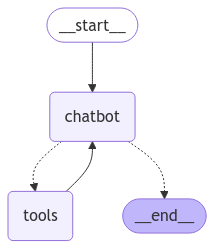

In [30]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [31]:
while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

User: q
Goodbye!


In [32]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

In [33]:
dir(memory)

['__abstractmethods__',
 '__aenter__',
 '__aexit__',
 '__annotations__',
 '__class__',
 '__class_getitem__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__enter__',
 '__eq__',
 '__exit__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__orig_bases__',
 '__parameters__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_is_protocol',
 'aget',
 'aget_tuple',
 'alist',
 'aput',
 'aput_writes',
 'config_specs',
 'get',
 'get_next_version',
 'get_tuple',
 'list',
 'put',
 'put_writes',
 'serde',
 'stack',
 'storage',
 'writes']

In [34]:
from typing import Annotated

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


tool = TavilySearchResults(max_results=2)
tools = [tool]
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

In [35]:
graph = graph_builder.compile(checkpointer=memory)

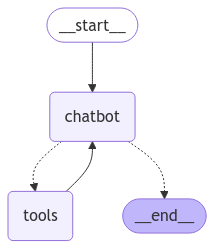

In [36]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [37]:
config = {"configurable": {"thread_id": "1"}}

In [38]:
user_input = "Hi there! My name is Will."

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Hi there! My name is Will.
================================== Ai Message ==================================

Nice to meet you, Will! How can I help you today?


In [39]:
snapshot = graph.get_state(config)
snapshot

StateSnapshot(values={'messages': [HumanMessage(content='Hi there! My name is Will.', additional_kwargs={}, response_metadata={}, id='615439a8-d6a3-4789-88bd-6c26a51af907'), AIMessage(content='Nice to meet you, Will! How can I help you today?', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-37a95558-700e-4739-b628-293e5303da01-0', usage_metadata={'input_tokens': 82, 'output_tokens': 15, 'total_tokens': 97, 'input_token_details': {'cache_read': 0}})]}, next=(), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1efe142b-1a20-6692-8001-8dc29fddb7c3'}}, metadata={'source': 'loop', 'writes': {'chatbot': {'messages': [AIMessage(content='Nice to meet you, Will! How can I help you today?', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-37a955

In [40]:
from typing import Annotated

from langchain_community.tools.tavily_search import TavilySearchResults
from typing_extensions import TypedDict

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

memory = MemorySaver()


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


tool = TavilySearchResults(max_results=2)
tools = [tool]
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

In [41]:
graph = graph_builder.compile(
    checkpointer=memory,
    # This is new!
    interrupt_before=["tools"],
    # Note: can also interrupt __after__ tools, if desired.
    # interrupt_after=["tools"]
)

In [42]:
user_input = "I AM LEARNING LANGGRAPH, COULD YOU SEARCH ON IT FOR ME"
config = {"configurable": {"thread_id": "3"}}
# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I AM LEARNING LANGGRAPH, COULD YOU SEARCH ON IT FOR ME
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (1e42cbd6-9f37-4972-b8c7-ddf71f648caa)
 Call ID: 1e42cbd6-9f37-4972-b8c7-ddf71f648caa
  Args:
    query: LangGraph


In [43]:
dir(graph)


['InputType',
 'OutputType',
 '__abstractmethods__',
 '__annotations__',
 '__class__',
 '__class_getitem__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__or__',
 '__orig_bases__',
 '__parameters__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__ror__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abatch_with_config',
 '_abc_impl',
 '_acall_with_config',
 '_aprepare_state_snapshot',
 '_atransform_stream_with_config',
 '_batch_with_config',
 '_call_with_config',
 '_defaults',
 '_is_protocol',
 '_prepare_state_snapshot',
 '_repr_mimebundle_',
 '_transform_stream_with_config',
 'abatch',
 'abatch_as_completed',
 'aget_graph',
 'aget_state',
 'aget_state_history',
 'aget_subgraphs',
 'ainvoke',
 'as_tool',
 'assign',
 'astream',
 'as

In [44]:
snapshot


StateSnapshot(values={'messages': [HumanMessage(content='Hi there! My name is Will.', additional_kwargs={}, response_metadata={}, id='615439a8-d6a3-4789-88bd-6c26a51af907'), AIMessage(content='Nice to meet you, Will! How can I help you today?', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-37a95558-700e-4739-b628-293e5303da01-0', usage_metadata={'input_tokens': 82, 'output_tokens': 15, 'total_tokens': 97, 'input_token_details': {'cache_read': 0}})]}, next=(), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1efe142b-1a20-6692-8001-8dc29fddb7c3'}}, metadata={'source': 'loop', 'writes': {'chatbot': {'messages': [AIMessage(content='Nice to meet you, Will! How can I help you today?', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-37a955

In [45]:
snapshot.config     # current state     thread id


{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1efe142b-1a20-6692-8001-8dc29fddb7c3'}}

In [46]:
snapshot = graph.get_state(config)


In [47]:
snapshot

StateSnapshot(values={'messages': [HumanMessage(content='I AM LEARNING LANGGRAPH, COULD YOU SEARCH ON IT FOR ME', additional_kwargs={}, response_metadata={}, id='e505a195-e979-4e0b-900e-d054ff6218ba'), AIMessage(content='', additional_kwargs={'function_call': {'name': 'tavily_search_results_json', 'arguments': '{"query": "LangGraph"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-bb5e7659-db5e-4641-ad45-99ef480549e4-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'LangGraph'}, 'id': '1e42cbd6-9f37-4972-b8c7-ddf71f648caa', 'type': 'tool_call'}], usage_metadata={'input_tokens': 87, 'output_tokens': 11, 'total_tokens': 98, 'input_token_details': {'cache_read': 0}})]}, next=('tools',), config={'configurable': {'thread_id': '3', 'checkpoint_ns': '', 'checkpoint_id': '1efe142b-2029-627f-8001-1ba5695ff4fb'}}, metadata={'source': 'loop', 'writes': {'chatbot': {'messages': [AIM

In [48]:
snapshot.next       # to check next node

('tools',)

In [49]:
snapshot.values

{'messages': [HumanMessage(content='I AM LEARNING LANGGRAPH, COULD YOU SEARCH ON IT FOR ME', additional_kwargs={}, response_metadata={}, id='e505a195-e979-4e0b-900e-d054ff6218ba'),
  AIMessage(content='', additional_kwargs={'function_call': {'name': 'tavily_search_results_json', 'arguments': '{"query": "LangGraph"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-bb5e7659-db5e-4641-ad45-99ef480549e4-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'LangGraph'}, 'id': '1e42cbd6-9f37-4972-b8c7-ddf71f648caa', 'type': 'tool_call'}], usage_metadata={'input_tokens': 87, 'output_tokens': 11, 'total_tokens': 98, 'input_token_details': {'cache_read': 0}})]}

In [50]:
snapshot.values['messages']

[HumanMessage(content='I AM LEARNING LANGGRAPH, COULD YOU SEARCH ON IT FOR ME', additional_kwargs={}, response_metadata={}, id='e505a195-e979-4e0b-900e-d054ff6218ba'),
 AIMessage(content='', additional_kwargs={'function_call': {'name': 'tavily_search_results_json', 'arguments': '{"query": "LangGraph"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-bb5e7659-db5e-4641-ad45-99ef480549e4-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'LangGraph'}, 'id': '1e42cbd6-9f37-4972-b8c7-ddf71f648caa', 'type': 'tool_call'}], usage_metadata={'input_tokens': 87, 'output_tokens': 11, 'total_tokens': 98, 'input_token_details': {'cache_read': 0}})]

In [51]:
existing_message = snapshot.values["messages"][-1]
existing_message.pretty_print()





================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (1e42cbd6-9f37-4972-b8c7-ddf71f648caa)
 Call ID: 1e42cbd6-9f37-4972-b8c7-ddf71f648caa
  Args:
    query: LangGraph


In [52]:
existing_message.tool_calls

[{'name': 'tavily_search_results_json',
  'args': {'query': 'LangGraph'},
  'id': '1e42cbd6-9f37-4972-b8c7-ddf71f648caa',
  'type': 'tool_call'}]

In [53]:
existing_message = snapshot.values["messages"][-1]
existing_message.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (1e42cbd6-9f37-4972-b8c7-ddf71f648caa)
 Call ID: 1e42cbd6-9f37-4972-b8c7-ddf71f648caa
  Args:
    query: LangGraph


In [54]:
[{'name': 'tavily_search_results_json',
  'args': {'query': 'LangGraph framework for building language model applications'},
  'id': 'toolu_01R4ZFcb5hohpiVZwr88Bxhc',
  'type': 'tool_call'}]

[{'name': 'tavily_search_results_json',
  'args': {'query': 'LangGraph framework for building language model applications'},
  'id': 'toolu_01R4ZFcb5hohpiVZwr88Bxhc',
  'type': 'tool_call'}]

In [55]:
# `None` will append nothing new to the current state, letting it resume as if it had never been interrupted
events = graph.stream(None, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (1e42cbd6-9f37-4972-b8c7-ddf71f648caa)
 Call ID: 1e42cbd6-9f37-4972-b8c7-ddf71f648caa
  Args:
    query: LangGraph
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://langchain-ai.github.io/langgraph/", "content": "Overview¶. LangGraph is a library for building stateful, multi-actor applications with LLMs, used to create agent and multi-agent workflows. Check out an introductory tutorial here.. LangGraph is inspired by Pregel and Apache Beam.The public interface draws inspiration from NetworkX.LangGraph is built by LangChain Inc, the creators of LangChain, but can be used without LangChain."}, {"url": "https://www.datacamp.com/tutorial/langgraph-tutorial", "content": "LangGraph is a library within the LangChain ecosystem that simplifies the development of complex, multi-agent large lang

In [56]:
from typing import Annotated

from langchain_community.tools.tavily_search import TavilySearchResults
from typing_extensions import TypedDict

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


tool = TavilySearchResults(max_results=2)
tools = [tool]
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
memory = MemorySaver()
graph = graph_builder.compile(
    checkpointer=memory,
    # This is new!
    interrupt_before=["tools"],
    # Note: can also interrupt **after** actions, if desired.
    # interrupt_after=["tools"]
)

user_input = "I'm learning LangGraph. search on it for me?"
config = {"configurable": {"thread_id": "4"}}
# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream({"messages": [("user", user_input)]}, config)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

In [57]:
snapshot = graph.get_state(config)


In [58]:
snapshot

StateSnapshot(values={'messages': [HumanMessage(content="I'm learning LangGraph. search on it for me?", additional_kwargs={}, response_metadata={}, id='46f0eac7-149f-42f9-9ac2-afce1d196710'), AIMessage(content='', additional_kwargs={'function_call': {'name': 'tavily_search_results_json', 'arguments': '{"query": "LangGraph"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-760259b1-bc9a-4a95-b5c1-f9fb30015f16-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'LangGraph'}, 'id': '127bf7bb-986b-4aa3-8e08-1bb168ee165e', 'type': 'tool_call'}], usage_metadata={'input_tokens': 87, 'output_tokens': 11, 'total_tokens': 98, 'input_token_details': {'cache_read': 0}})]}, next=('tools',), config={'configurable': {'thread_id': '4', 'checkpoint_ns': '', 'checkpoint_id': '1efe142b-454b-67ef-8001-11da006db835'}}, metadata={'source': 'loop', 'writes': {'chatbot': {'messages': [AIMessage(con

In [59]:
existing_message = snapshot.values["messages"][-1]
existing_message.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (127bf7bb-986b-4aa3-8e08-1bb168ee165e)
 Call ID: 127bf7bb-986b-4aa3-8e08-1bb168ee165e
  Args:
    query: LangGraph


In [60]:
from langchain_core.messages import AIMessage, ToolMessage

tavily_answer = (
    "LangGraph is a library for building stateful, multi-actor applications with LLMs, used to create agent and multi-agent workflows.  It's part of the LangChain ecosystem and draws inspiration from Pregel and Apache Beam.  You can find more information and tutorials online."
)
new_messages = [
    ToolMessage(content=tavily_answer, tool_call_id=existing_message.tool_calls[0]["id"]),
    AIMessage(content=tavily_answer),
]

In [61]:
new_messages[-1].pretty_print()

================================== Ai Message ==================================

LangGraph is a library for building stateful, multi-actor applications with LLMs, used to create agent and multi-agent workflows.  It's part of the LangChain ecosystem and draws inspiration from Pregel and Apache Beam.  You can find more information and tutorials online.


In [62]:
for m in new_messages:
  m.pretty_print()

================================= Tool Message =================================

LangGraph is a library for building stateful, multi-actor applications with LLMs, used to create agent and multi-agent workflows.  It's part of the LangChain ecosystem and draws inspiration from Pregel and Apache Beam.  You can find more information and tutorials online.
================================== Ai Message ==================================

LangGraph is a library for building stateful, multi-actor applications with LLMs, used to create agent and multi-agent workflows.  It's part of the LangChain ecosystem and draws inspiration from Pregel and Apache Beam.  You can find more information and tutorials online.


In [63]:


graph.update_state(
    config,
    {"messages": new_messages},
)


{'configurable': {'thread_id': '4',
  'checkpoint_ns': '',
  'checkpoint_id': '1efe142b-479b-687f-8002-eec311e5f485'}}

In [64]:

print("\n\nLast 2 messages;")
print (graph.get_state(config).values["messages"][-2:])



Last 2 messages;
[ToolMessage(content="LangGraph is a library for building stateful, multi-actor applications with LLMs, used to create agent and multi-agent workflows.  It's part of the LangChain ecosystem and draws inspiration from Pregel and Apache Beam.  You can find more information and tutorials online.", id='94881f7a-d061-4c90-b646-96cc2b2ce538', tool_call_id='127bf7bb-986b-4aa3-8e08-1bb168ee165e'), AIMessage(content="LangGraph is a library for building stateful, multi-actor applications with LLMs, used to create agent and multi-agent workflows.  It's part of the LangChain ecosystem and draws inspiration from Pregel and Apache Beam.  You can find more information and tutorials online.", additional_kwargs={}, response_metadata={}, id='32916c2a-39ba-4a7b-9ab5-f3f7f55736fb')]


In [65]:
for m in graph.get_state(config).values["messages"]:
  m.pretty_print()

================================ Human Message =================================

I'm learning LangGraph. search on it for me?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (127bf7bb-986b-4aa3-8e08-1bb168ee165e)
 Call ID: 127bf7bb-986b-4aa3-8e08-1bb168ee165e
  Args:
    query: LangGraph
================================= Tool Message =================================

LangGraph is a library for building stateful, multi-actor applications with LLMs, used to create agent and multi-agent workflows.  It's part of the LangChain ecosystem and draws inspiration from Pregel and Apache Beam.  You can find more information and tutorials online.
================================== Ai Message ==================================

LangGraph is a library for building stateful, multi-actor applications with LLMs, used to create agent and multi-agent workflows.  It's part of the LangChain ecosystem and draws inspiration from Prege

In [66]:
snapshot = graph.get_state(config)
snapshot.next     # ()   no any node because graph end

()

In [67]:
graph.update_state(
    config,
    {"messages": [AIMessage(content="i am an exper in ai agents")]},
    as_node="chatbot",
)

{'configurable': {'thread_id': '4',
  'checkpoint_ns': '',
  'checkpoint_id': '1efe142b-48ca-61a8-8003-e78d5944a683'}}

In [68]:
for m in graph.get_state(config).values["messages"]:
  m.pretty_print()      # swaped with two ai messages by last message

================================ Human Message =================================

I'm learning LangGraph. search on it for me?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (127bf7bb-986b-4aa3-8e08-1bb168ee165e)
 Call ID: 127bf7bb-986b-4aa3-8e08-1bb168ee165e
  Args:
    query: LangGraph
================================= Tool Message =================================

LangGraph is a library for building stateful, multi-actor applications with LLMs, used to create agent and multi-agent workflows.  It's part of the LangChain ecosystem and draws inspiration from Pregel and Apache Beam.  You can find more information and tutorials online.
================================== Ai Message ==================================

LangGraph is a library for building stateful, multi-actor applications with LLMs, used to create agent and multi-agent workflows.  It's part of the LangChain ecosystem and draws inspiration from Prege

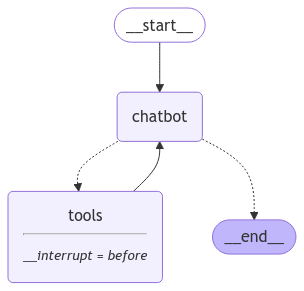

In [69]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [70]:
snapshot = graph.get_state(config)
print(snapshot.values["messages"][-3:])
print(snapshot.next)

[ToolMessage(content="LangGraph is a library for building stateful, multi-actor applications with LLMs, used to create agent and multi-agent workflows.  It's part of the LangChain ecosystem and draws inspiration from Pregel and Apache Beam.  You can find more information and tutorials online.", id='94881f7a-d061-4c90-b646-96cc2b2ce538', tool_call_id='127bf7bb-986b-4aa3-8e08-1bb168ee165e'), AIMessage(content="LangGraph is a library for building stateful, multi-actor applications with LLMs, used to create agent and multi-agent workflows.  It's part of the LangChain ecosystem and draws inspiration from Pregel and Apache Beam.  You can find more information and tutorials online.", additional_kwargs={}, response_metadata={}, id='32916c2a-39ba-4a7b-9ab5-f3f7f55736fb'), AIMessage(content='i am an exper in ai agents', additional_kwargs={}, response_metadata={}, id='cfd6a5d1-b190-45aa-b793-cd19557546d3')]
()


In [71]:

from langchain_core.messages import HumanMessage
user_goals = [HumanMessage(id=1, content="i want to learn ai")]
updated_goals = [HumanMessage(id=1, content="i want to learn ai with tools")]

In [72]:
final_goals = add_messages(user_goals, updated_goals)
print(final_goals)      # when id 1

[HumanMessage(content='i want to learn ai with tools', additional_kwargs={}, response_metadata={}, id='1')]


In [73]:
# from langchain_core.messages import HumanMessage
# user_goals = [HumanMessage(id=1, content="i want to learn ai")]
# updated_goals = [HumanMessage(id=2, content="i want to learn ai with tools")]

In [74]:
# final_goals = add_messages(user_goals, updated_goals)
# print(final_goals)      # when id 2

In [75]:
user_input = "I'm learning LangGraph. search it for me?"
config = {"configurable": {"thread_id": "5"}}

events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I'm learning LangGraph. search it for me?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (7cff7dec-04bc-472f-a665-6b7ae13d8427)
 Call ID: 7cff7dec-04bc-472f-a665-6b7ae13d8427
  Args:
    query: LangGraph


In [76]:
from langchain_core.messages import AIMessage

snapshot = graph.get_state(config)

In [77]:
existing_message = snapshot.values["messages"][-1]
print("original")
print(existing_message.pretty_print())
print("message id", existing_message.id)
print(existing_message.tool_calls[0])

original
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (7cff7dec-04bc-472f-a665-6b7ae13d8427)
 Call ID: 7cff7dec-04bc-472f-a665-6b7ae13d8427
  Args:
    query: LangGraph
None
message id run-464d854d-128e-45e5-a460-83a91ca506e0-0
{'name': 'tavily_search_results_json', 'args': {'query': 'LangGraph'}, 'id': '7cff7dec-04bc-472f-a665-6b7ae13d8427', 'type': 'tool_call'}


In [78]:
new_tool_call = existing_message.tool_calls[0].copy()
new_tool_call["args"]["query"] = "human-in-the-loop workflow"
new_message = AIMessage(
    content=existing_message.content,
    tool_calls=[new_tool_call],
    id=existing_message.id,
)



In [79]:
new_message.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (7cff7dec-04bc-472f-a665-6b7ae13d8427)
 Call ID: 7cff7dec-04bc-472f-a665-6b7ae13d8427
  Args:
    query: human-in-the-loop workflow


In [80]:
print("updated")
print(new_message.tool_calls[0])
print("message id", new_message.id)

updated
{'name': 'tavily_search_results_json', 'args': {'query': 'human-in-the-loop workflow'}, 'id': '7cff7dec-04bc-472f-a665-6b7ae13d8427', 'type': 'tool_call'}
message id run-464d854d-128e-45e5-a460-83a91ca506e0-0


In [81]:
graph.update_state(config, {"messages": [new_message]})
print("\n\nTool calls")
graph.get_state(config).values["messages"][-1].tool_calls



Tool calls


[{'name': 'tavily_search_results_json',
  'args': {'query': 'human-in-the-loop workflow'},
  'id': '7cff7dec-04bc-472f-a665-6b7ae13d8427',
  'type': 'tool_call'}]

In [82]:
for m in graph.get_state(config).values["messages"]:
  m.pretty_print()

================================ Human Message =================================

I'm learning LangGraph. search it for me?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (7cff7dec-04bc-472f-a665-6b7ae13d8427)
 Call ID: 7cff7dec-04bc-472f-a665-6b7ae13d8427
  Args:
    query: human-in-the-loop workflow


In [83]:
events = graph.stream(None, config, stream_mode="values")
for event in events:
  if "messages" in event:
    event["messages"][-1].pretty_print()


================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (7cff7dec-04bc-472f-a665-6b7ae13d8427)
 Call ID: 7cff7dec-04bc-472f-a665-6b7ae13d8427
  Args:
    query: human-in-the-loop workflow
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://camunda.com/blog/2024/06/what-is-human-in-the-loop-automation/", "content": "Human in the Loop (HITL) automation is a hybrid approach where automated systems and human judgment are integrated into a single workflow. Unlike full automation, which operates without any human input, HITL ensures that humans can intervene at specific stages to provide oversight, make decisions, and guide the automation process."}, {"url": "https://nordicapis.com/what-is-human-in-the-loop-workflow-automation/", "content": "HITL: Human Automation Hybrid Ultimately, Human-in-the-Loop is a useful paradigm when implemented within th

In [84]:
from typing import Annotated

from langchain_community.tools.tavily_search import TavilySearchResults
from typing_extensions import TypedDict

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.graph.message import add_messages


class State(TypedDict):
    messages: Annotated[list, add_messages]
    name: str
    ask_human: bool

In [85]:
from pydantic import BaseModel

class RequestAssistance(BaseModel):
  """esclate the converstion to an expert"""
  request: str

In [86]:
abc = RequestAssistance(request="i need help")
print(abc)
print(abc.request)

request='i need help'
i need help


In [87]:
tool = TavilySearchResults(max_results=2)
tools = [tool]
llm_with_tools = llm.bind_tools(tools + [RequestAssistance])

In [88]:
llm_with_tools

RunnableBinding(bound=ChatGoogleGenerativeAI(model='models/gemini-1.5-flash', google_api_key=SecretStr('**********'), max_retries=2, client=<google.ai.generativelanguage_v1beta.services.generative_service.client.GenerativeServiceClient object at 0x79ee112e99d0>, default_metadata=()), kwargs={'tools': [{'type': 'function', 'function': {'name': 'tavily_search_results_json', 'description': 'A search engine optimized for comprehensive, accurate, and trusted results. Useful for when you need to answer questions about current events. Input should be a search query.', 'parameters': {'properties': {'query': {'description': 'search query to look up', 'type': 'string'}}, 'required': ['query'], 'type': 'object'}}}, {'type': 'function', 'function': {'name': 'RequestAssistance', 'description': 'esclate the converstion to an expert', 'parameters': {'properties': {'request': {'type': 'string'}}, 'required': ['request'], 'type': 'object'}}}]}, config={}, config_factories=[])

In [103]:
response = llm_with_tools.invoke("connect me with a langraph expert for paid project")
response.pretty_print()       # connected with human

================================== Ai Message ==================================
Tool Calls:
  RequestAssistance (52490c6d-60d5-4656-b480-ea112d783f0e)
 Call ID: 52490c6d-60d5-4656-b480-ea112d783f0e
  Args:
    request: connect me with a langraph expert for paid project


In [90]:
response = llm_with_tools.invoke("search about langraph expert for paid project")
response.pretty_print()       # searching using tavily

================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (4aa1f6d7-6a33-4bb8-8bc9-d340040cb8dc)
 Call ID: 4aa1f6d7-6a33-4bb8-8bc9-d340040cb8dc
  Args:
    query: langraph expert for paid project


In [91]:
response = llm_with_tools.invoke("hello")
response.pretty_print()       # replying by itself

================================== Ai Message ==================================

Hello! How can I help you today?


In [92]:
def chatbot(state: State):
    message = llm_with_tools.invoke(state["messages"])
    ask_human = False
    if (
        response.tool_calls
        and response.tool_calls[0]["name"] == RequestAssistance.__name__
    ):
        ask_human = True
    return {"messages": [message], "ask_human": ask_human}

In [93]:
graph_builder = StateGraph(State)
graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", ToolNode(tools=[tool]))

In [94]:
from langchain_core.messages import AIMessage, ToolMessage

def create_response(response: str, ai_message: AIMessage):
  return ToolMessage(
      content=response,
      tool_call_id=ai_message.tool_calls[0]["id"],
  )


def human_node(state: State):
  new_messages = []
  if not isinstance(state["messages"][-1], ToolMessage):
    new_messages.append(
      create_response("no response from human.", state["messages"][-1])
    )
  return{
        "messages": new_messages,
        "ask_human": False,
    }

graph_builder.add_node("human", human_node)


In [95]:
def select_next_node(state: State):
  if state["ask_human"]:
     return "human"
  return tools_condition(state)

graph_builder.add_conditional_edges(
    "chatbot",
    select_next_node,
    {"human": "human", "tools": "tools", END: END}
)

In [96]:

graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge("human", "chatbot")
memory = MemorySaver()
graph = graph_builder.compile(
    checkpointer=memory,
    interrupt_before=["human"]
)

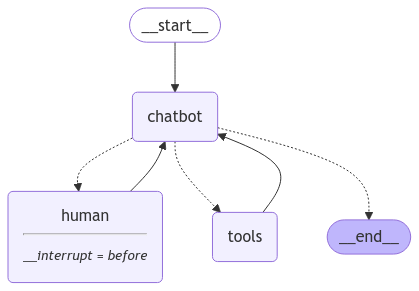

In [97]:
from IPython.display import Image, display

try:
  display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
  pass

In [105]:
user_input = "I need some expert guidence for building this ai agent, could you request assistant for me?"
config = {"configurable": {"thread_id": "71"}}

events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    if "messages" in event:
      event["messages"][-1].pretty_print()

================================ Human Message =================================

I need some expert guidence for building this ai agent, could you request assistant for me?
================================== Ai Message ==================================
Tool Calls:
  RequestAssistance (dce12075-5d10-4ebb-8973-0d1cfd900fb5)
 Call ID: dce12075-5d10-4ebb-8973-0d1cfd900fb5
  Args:
    request: I need some expert guidence for building this ai agent.


In [106]:
snapshot = graph.get_state(config)
snapshot.next

('human',)

In [107]:
ai_message = snapshot.values["messages"][-1]
human_response = (
    "We, the experts are here to help! We'd recommend you check out LangGraph to build your agent."
    " It's much more reliable and extensible than simple autonomous agents."
)

if ai_message.tool_calls:
    tool_message = create_response(human_response, ai_message)
else:
    # Handle the case where tool_calls is empty
    print("No tool calls found")




In [108]:
tool_message.pretty_print()

================================= Tool Message =================================

We, the experts are here to help! We'd recommend you check out LangGraph to build your agent. It's much more reliable and extensible than simple autonomous agents.


In [109]:
graph.update_state(config, {"messages": [tool_message]})

{'configurable': {'thread_id': '71',
  'checkpoint_ns': '',
  'checkpoint_id': '1efe1436-be3d-6833-8002-2868f853980d'}}

In [110]:
graph.get_state(config).values["messages"]

[HumanMessage(content='I need some expert guidence for building this ai agent, could you request assistant for me?', additional_kwargs={}, response_metadata={}, id='9cc156e5-5354-4993-acc0-4e58c7cd072b'),
 AIMessage(content='', additional_kwargs={'function_call': {'name': 'RequestAssistance', 'arguments': '{"request": "I need some expert guidence for building this ai agent."}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-39193bad-b5a3-4e21-9f46-0a3f5715ccf7-0', tool_calls=[{'name': 'RequestAssistance', 'args': {'request': 'I need some expert guidence for building this ai agent.'}, 'id': 'dce12075-5d10-4ebb-8973-0d1cfd900fb5', 'type': 'tool_call'}], usage_metadata={'input_tokens': 133, 'output_tokens': 15, 'total_tokens': 148, 'input_token_details': {'cache_read': 0}}),
 ToolMessage(content="We, the experts are here to help! We'd recommend you check out LangGraph to build your agent. It's much

In [111]:
events = graph.stream(None, config, stream_mode="values")

for event in events:
    if "messages" in event:
      event["messages"][-1].pretty_print()

================================= Tool Message =================================

We, the experts are here to help! We'd recommend you check out LangGraph to build your agent. It's much more reliable and extensible than simple autonomous agents.
================================= Tool Message =================================

We, the experts are here to help! We'd recommend you check out LangGraph to build your agent. It's much more reliable and extensible than simple autonomous agents.


ChatGoogleGenerativeAIError: Invalid argument provided to Gemini: 400 * GenerateContentRequest.contents[2].parts[0].function_response.name: Name cannot be empty.


In [112]:
for m in graph.get_state(config).values["messages"]:
  m.pretty_print()

================================ Human Message =================================

I need some expert guidence for building this ai agent, could you request assistant for me?
================================== Ai Message ==================================
Tool Calls:
  RequestAssistance (dce12075-5d10-4ebb-8973-0d1cfd900fb5)
 Call ID: dce12075-5d10-4ebb-8973-0d1cfd900fb5
  Args:
    request: I need some expert guidence for building this ai agent.
================================= Tool Message =================================

We, the experts are here to help! We'd recommend you check out LangGraph to build your agent. It's much more reliable and extensible than simple autonomous agents.


In [113]:
config = {"configurable": {"thread_id": "101"}}
events = graph.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": (
                    "hello!, I'm learning ai agents. "

                ),
            },
        ],
    },
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

hello!, I'm learning ai agents. 
================================== Ai Message ==================================

Hello!  I can help you learn about AI agents. What specifically about AI agents are you interested in learning?  For example, are you interested in a particular type of AI agent, a specific application, or the underlying concepts?  The more detail you provide, the better I can assist you.


In [114]:
events = graph.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": (
                    "Ya that's helpful. Maybe I'll "
                    "build an autonomous agent with it!"
                ),
            },
        ],
    },
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

Ya that's helpful. Maybe I'll build an autonomous agent with it!
================================== Ai Message ==================================

That's a great goal! Building an autonomous agent is a challenging but rewarding project. To help you get started, let's break down the process.  We need to consider several key aspects:

1. **Define the Environment:** What kind of environment will your agent operate in?  Will it be a simulated environment (like a game) or a real-world environment?  The environment dictates the types of sensors and actions your agent will need.

2. **Define the Agent's Goals:** What is the agent supposed to achieve?  This is crucial for designing the reward function and the overall agent architecture.  A clear objective helps guide the development process.

3. **Choose an Agent Architecture:**  There are several options, each with its strengths and weaknesses:
    * **Rule-base

In [115]:
to_replay = []
for state in graph.get_state_history(config):
  print(state)
  to_replay.append(state)

StateSnapshot(values={'messages': [HumanMessage(content="hello!, I'm learning ai agents. ", additional_kwargs={}, response_metadata={}, id='fd290614-0b55-473a-8051-e6df92c766bf'), AIMessage(content='Hello!  I can help you learn about AI agents. What specifically about AI agents are you interested in learning?  For example, are you interested in a particular type of AI agent, a specific application, or the underlying concepts?  The more detail you provide, the better I can assist you.', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-8f2d08b3-e9ea-4b52-a735-6b908b1945a1-0', usage_metadata={'input_tokens': 124, 'output_tokens': 62, 'total_tokens': 186, 'input_token_details': {'cache_read': 0}}), HumanMessage(content="Ya that's helpful. Maybe I'll build an autonomous agent with it!", additional_kwargs={}, response_metadata={}, id='717ae4d1-1350-455d-adac-f573e4c846bb'), AIMessage

In [116]:
to_replay = None
for state in graph.get_state_history(config):
    print("Num Messages: ", len(state.values["messages"]), "Next: ", state.next)
    print("-" * 80)
    if len(state.values["messages"]) == 1:
        # We are somewhat arbitrarily selecting a specific state based on the number of chat messages in the state.
        to_replay = state

Num Messages:  4 Next:  ('human',)
--------------------------------------------------------------------------------
Num Messages:  3 Next:  ('chatbot',)
--------------------------------------------------------------------------------
Num Messages:  2 Next:  ('__start__',)
--------------------------------------------------------------------------------
Num Messages:  2 Next:  ('human',)
--------------------------------------------------------------------------------
Num Messages:  1 Next:  ('chatbot',)
--------------------------------------------------------------------------------
Num Messages:  0 Next:  ('__start__',)
--------------------------------------------------------------------------------


In [117]:
print(to_replay.next)
print(to_replay.config)

('chatbot',)
{'configurable': {'thread_id': '101', 'checkpoint_ns': '', 'checkpoint_id': '1efe1437-0e9f-6b44-8000-241d9a6c457c'}}


In [118]:
print(to_replay)

StateSnapshot(values={'messages': [HumanMessage(content="hello!, I'm learning ai agents. ", additional_kwargs={}, response_metadata={}, id='fd290614-0b55-473a-8051-e6df92c766bf')]}, next=('chatbot',), config={'configurable': {'thread_id': '101', 'checkpoint_ns': '', 'checkpoint_id': '1efe1437-0e9f-6b44-8000-241d9a6c457c'}}, metadata={'source': 'loop', 'writes': None, 'thread_id': '101', 'step': 0, 'parents': {}}, created_at='2025-02-02T08:55:24.521527+00:00', parent_config={'configurable': {'thread_id': '101', 'checkpoint_ns': '', 'checkpoint_id': '1efe1437-0e86-686c-bfff-4fceef0f5af1'}}, tasks=(PregelTask(id='b08d1bc7-078b-8f92-3e01-81f2e2fe7808', name='chatbot', path=('__pregel_pull', 'chatbot'), error=None, interrupts=(), state=None, result={'messages': [AIMessage(content='Hello!  I can help you learn about AI agents. What specifically about AI agents are you interested in learning?  For example, are you interested in a particular type of AI agent, a specific application, or the und

In [120]:
config = {"configurable": {"thread id": 200}}

In [119]:


while True:
    try:
        # Get user input
        user_input = input("User: ")

        # Check if the user wants to quit
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break


        # Ensure that the configuration is correct for Checkpointer
        # You might need to define a config dictionary with the required keys
        config = {
            'thread_id': config,  # Thread ID dynamically obtained
            'checkpoint_ns': '',  # Define the checkpoint namespace
            'checkpoint_id': '1efe0040-c516-61f4-8000-1c3d5770ed83'  # Use the generated checkpoint ID
        }

        # Assuming stream_graph_updates is part of LangGraph, pass the config to it
        # Modify stream_graph_updates to accept the config if needed
        stream_graph_updates(user_input)

    except ValueError as e:
        # Handle ValueError specifically, especially from LangGraph's Checkpointer
        print(f"Error: {e}")
        # You can decide if you want to continue or exit on error
        continue

    except Exception as e:
        # Catch other exceptions and print the error
        print(f"Unexpected error: {e}")
        break  # Exit loop in case of unexpected error




User: hi
Error: Checkpointer requires one or more of the following 'configurable' keys: ['thread_id', 'checkpoint_ns', 'checkpoint_id']
User: q
Goodbye!


In [121]:
snapshot = graph.get_state(config)
print(snapshot)

KeyError: 'thread_id'

In [122]:
while True:
    try:
        # Get user input
        user_input = input("User: ")

        # Check if the user wants to quit
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        # Ensure that the configuration is correct for Checkpointer
        config = {
            'thread_id': '71',  # Thread ID dynamically obtained
            'checkpoint_ns': '',  # Define the checkpoint namespace if needed
            'checkpoint_id': '1efe0040-c516-61f4-8000-1c3d5770ed83'  # Use the generated checkpoint ID
        }

        # Assuming stream_graph_updates is part of LangGraph, pass the config to it
        # Modify stream_graph_updates to accept the config if needed
        stream_graph_updates(user_input)

        # If using the stream functionality as per the original code snippet
        events = graph.stream(
            {"messages": [("user", user_input)]}, config, stream_mode="values"
        )

        # Process the event if "messages" is present
        for event in events:
            if "messages" in event:
                # Assuming pretty_print method exists to display the message content
                event["messages"][-1].pretty_print()

    except ValueError as e:
        # Handle ValueError specifically, especially from LangGraph's Checkpointer
        print(f"Error: {e}")
        # You can decide if you want to continue or exit on error
        continue

    except Exception as e:
        # Catch other exceptions and print the error
        print(f"Unexpected error: {e}")
        break  # Exit loop in case of unexpected error


User: hi
Error: Checkpointer requires one or more of the following 'configurable' keys: ['thread_id', 'checkpoint_ns', 'checkpoint_id']
User: q
Goodbye!
